# Training CIFAR-10 on a small CNN

https://arxiv.org/pdf/1412.6806.pdf

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models

from datetime import datetime
import cv2

In [7]:
import os
from tqdm import tqdm_notebook

In [8]:
PATH = Path("/data2/yinterian/data/")

## Import data from torchvision

If no transforms are provided, torchvision returns PIL objects

In [9]:
train_set = datasets.CIFAR10(root=PATH/'cifardata', 
                                         train=True, download=True)
test_set = datasets.CIFAR10(root=PATH/'cifardata', 
                                        train=False, download=True)
test_set, valid_set = torch.utils.data.random_split(test_set,(5000,5000))

Files already downloaded and verified


In [42]:
x, y = train_set[200]
y

6

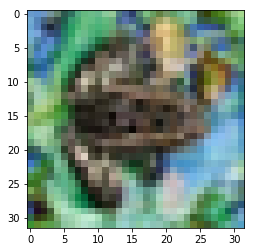

In [43]:
plt.imshow(x)

In [44]:
x = np.array(x)
x.shape

(32, 32, 3)

In [46]:
pad = 4
x = cv2.copyMakeBorder(x, pad, pad, pad, pad, cv2.BORDER_REFLECT)

(40, 40, 3)

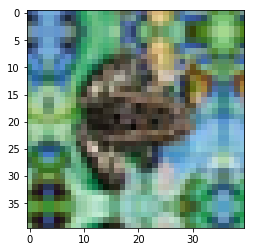

In [48]:
plt.imshow(x)
x.shape

## Preprocessing 

In [52]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [177]:
def get_base_path(path):
    return os.path.split(path)[0] + "/"

In [184]:
df = pd.read_csv(PATH/"MURA-v1.1/train_image_paths.csv", header=None, names=["image_name"])
df2 = pd.read_csv(PATH/"MURA-v1.1/train_labeled_studies.csv", header=None, names=["path", "label"])
df["path"] = df["image_name"].apply(get_base_path)
result = pd.merge(df, df2, on='path')
result["image_id"] = result.index
result.to_csv(PATH/"MURA-v1.1/train_path_labels.csv")

In [185]:
df3 = pd.read_csv(PATH/"MURA-v1.1/valid_image_paths.csv", header=None, names=["image_name"])
df4 = pd.read_csv(PATH/"MURA-v1.1/valid_labeled_studies.csv", header=None, names=["path", "label"])
df3["path"] = df3["image_name"].apply(get_base_path)
result2 = pd.merge(df3, df4, on='path')
result2["image_id"] = result2.index
result2.to_csv(PATH/"MURA-v1.1/valid_path_labels.csv")

In [187]:
result2.head()

,image_name,path,label,image_id
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,0
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,2
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,3
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,4


In [25]:
sizes = [read_image(PATH/x).shape for x in df["image_name"].values]

In [49]:
np.quantile([x[0] for x in sizes], 0.001)

177.80700000000002

In [28]:
sz = {}
for x in sizes:
    sz[x] = sz.get(x, 0) + 1

In [32]:
sz2 = {}
for x in sizes:
    ratio = x[0]/x[1]
    key = str(round(ratio,1))
    sz2[key] = sz2.get(key, 0) + 1

In [38]:
x, y = [float(x) for x in sz2.keys()], sz2.values()

<BarContainer object of 50 artists>

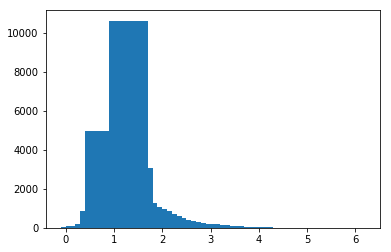

In [41]:
plt.bar(x, y)

In [56]:
df.head()

,image_name
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [118]:
path = PATH/df["image_name"].values[74]
path

PosixPath('/data2/yinterian/mura/MURA-v1.1/train/XR_SHOULDER/patient00027/study1_positive/image1.png')

(512, 406, 3)

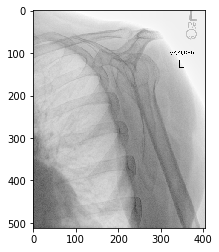

In [113]:
im = read_image(path)
plt.imshow(im)
im.shape

In [120]:
def get_a_crop(path, sz=(270, 350)):
    im = cv2.imread(str(path))
    r,c,_ = im.shape
    ratio = r/c
    if ratio > 1.3:
        pad = int((r/1.3-c)/2)
        im2 = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_CONSTANT)
    else:
        pad = int((1.3*c -r)/2)
        im2 = cv2.copyMakeBorder(im, pad, pad , 0, 0, cv2.BORDER_CONSTANT)
    return cv2.resize(im2, sz)

(350, 270, 3)

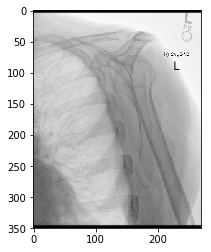

In [121]:
im2 = get_a_crop(path)
plt.imshow(im2)
im2.shape

In [194]:
from os import listdir
from os.path import join
def resize_all_images(df, new_dir):
    for i in range(len(df)):
        row = df.iloc[i,:]
        f = PATH/row["image_name"]
        img = get_a_crop(f)
        new_path = new_dir/"image-{}.png".format(row["image_id"])
        cv2.imwrite(str(new_path), img)

In [195]:
df = pd.read_csv(PATH/"MURA-v1.1/train_path_labels.csv")
df[:4]

,Unnamed: 0,image_name,path,label,image_id
0,0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0
1,1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,1
2,2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,2
3,3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,3


In [196]:
#resize_all_images(df, PATH/"train_350_270")

In [197]:
df2 = pd.read_csv(PATH/"MURA-v1.1/valid_path_labels.csv")
#resize_all_images(df2, PATH/"valid_350_270")

In [ ]:
df = pd.read_csv(PATH/"MURA-v1.1/train_image_paths.csv", header=None, names=["image_name"])

In [123]:
PATH

PosixPath('/data2/yinterian/mura')

In [116]:
512/406

1.2610837438423645

In [85]:
512/407

1.257985257985258

In [82]:
r/1.3-c

14.846153846153811

## Random transforms

In [24]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=4):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=4):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Dataset

In [91]:
class CIFAR10(Dataset):
    """
    Basic Images DataSet
    Args:
        dataset: dataset with data
        transform: True for training otherwise False
    """

    def __init__(self, dataset, transform=False):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, y = self.dataset[index]
        x = np.array(img) / 255
        if self.transform:
            pad = 4
            x = cv2.copyMakeBorder(x, pad, pad, pad, pad, cv2.BORDER_REFLECT)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        
        return np.rollaxis(x, 2), y

    def __len__(self):
        return len(self.dataset)

In [224]:
train_ds = CIFAR10(train_set, transform=True)
valid_ds = CIFAR10(valid_set)
test_ds = CIFAR10(test_set)

In [133]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size,  shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [134]:
x, y = train_ds[0]
x.shape

(3, 32, 32)

In [135]:
x, y = valid_ds[0]
x.shape

(3, 32, 32)

## Model 

AllConvNet is taken from the paper https://arxiv.org/pdf/1412.6806.pdf. It is a all convolution network that replaces max_pooling with stride2 convolutions. I added Batchnorm to every layer.

In [228]:
class AllConvNet(nn.Module):
    def __init__(self, nc=3, n_classes=10, **kwargs):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(nc, 96, 3, padding=1)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1)
        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2)
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1)
        self.conv5 = nn.Conv2d(192, 192, 3, padding=1)
        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2)
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1)
        self.conv8 = nn.Conv2d(192, 192, 1)

        self.bn1 = nn.BatchNorm2d(96)
        self.bn2 = nn.BatchNorm2d(96)
        self.bn3 = nn.BatchNorm2d(96)
        self.bn4 = nn.BatchNorm2d(192)
        self.bn5 = nn.BatchNorm2d(192)
        self.bn6 = nn.BatchNorm2d(192)
        self.bn7 = nn.BatchNorm2d(192)
        self.bn8 = nn.BatchNorm2d(192)
        self.bn9 = nn.BatchNorm2d(n_classes)
        
        self.class_conv = nn.Conv2d(192, n_classes, 1)

    def forward(self, x):
        #x = F.dropout(x, .1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        #x = F.dropout(x, .1)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        #x = F.dropout(x, .1)
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))

        class_out = F.relu(self.bn9(self.class_conv(x)))
        pool_out = F.adaptive_avg_pool2d(class_out, 1)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out

In [197]:
model = AllConvNet().cuda()

In [198]:
x,y = next(iter(train_dl))
x = x.float().cuda()
y = y.cuda()

In [199]:
# soft predictions
pred = model(x)
pred

tensor([[0.0689, 0.0245, 0.0113,  ..., 0.0000, 0.0000, 0.0000],
        [0.0685, 0.0242, 0.0119,  ..., 0.0000, 0.0000, 0.0000],
        [0.0693, 0.0241, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0695, 0.0241, 0.0124,  ..., 0.0000, 0.0000, 0.0000],
        [0.0693, 0.0243, 0.0119,  ..., 0.0000, 0.0000, 0.0000],
        [0.0691, 0.0243, 0.0114,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SqueezeBackward3>)

In [159]:
# hard predcitions
_, hard_pred = torch.max(pred, 1)
hard_pred.shape

torch.Size([5])

In [152]:
F.cross_entropy(pred, y).item()

2.3199639320373535

In [160]:
# correctly classified
(hard_pred == y).sum()

tensor(0, device='cuda:0')

## Metric: accuracy

In [154]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size,  shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [163]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        pred = model(x)
        loss = F.cross_entropy(pred, y)
        _, hard_pred = torch.max(pred, 1)
        correct += (hard_pred == y).sum()
        sum_loss += batch*(loss.item())
        total += batch
    
    return sum_loss/total, correct.item()/total

In [164]:
val_metric(model, valid_dl)

(2.303215809249878, 0.0992)

## Training functions

In [165]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

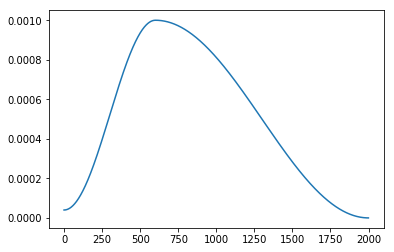

In [166]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [173]:
def create_optimizer(model, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return optimizer

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [186]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_auc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            update_optimizer(optimizer, lrs[idx])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % 
              (train_loss, val_loss, val_acc))
    return sum_loss/total

In [177]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    optimizer = create_optimizer(model, lrs[0])
    model.train()
    ind = 0
    prev_loss = 0
    for i in range(epochs):
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, lr)
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append((prev_loss + loss.item())/2)
            prev_loss = loss.item()
            ind +=1
            
    load_model(model, str(p))
    return lrs[1:], losses[1:]

In [178]:
model = AllConvNet().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_high=0.01)

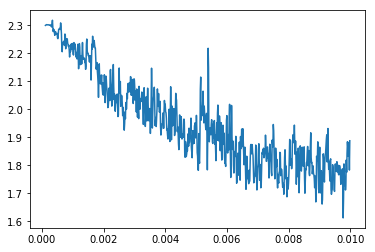

In [180]:
plt.plot(lrs, losses)
plt.show()

## Run Training

Note that in the original paper the authors trained for 350 epochs. We obtain the same results with 25 epochs.

In [213]:
# excluding top dropout
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 8)

train_loss 1.852 val_loss 1.664 val_acc 0.444
train_loss 1.167 val_loss 1.550 val_acc 0.468
train_loss 0.853 val_loss 0.991 val_acc 0.669
train_loss 0.660 val_loss 0.657 val_acc 0.775
train_loss 0.547 val_loss 0.540 val_acc 0.815
train_loss 0.445 val_loss 0.440 val_acc 0.854
train_loss 0.367 val_loss 0.371 val_acc 0.869
train_loss 0.322 val_loss 0.362 val_acc 0.876


0.32197575662612915

In [215]:
# no drop out
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 8)

train_loss 1.704 val_loss 1.982 val_acc 0.362
train_loss 1.137 val_loss 1.167 val_acc 0.606
train_loss 0.822 val_loss 0.942 val_acc 0.679
train_loss 0.634 val_loss 0.795 val_acc 0.733
train_loss 0.524 val_loss 0.606 val_acc 0.796
train_loss 0.418 val_loss 0.409 val_acc 0.866
train_loss 0.339 val_loss 0.340 val_acc 0.888
train_loss 0.286 val_loss 0.326 val_acc 0.891


0.2862458397483826

In [216]:
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 10)

train_loss 1.875 val_loss 1.808 val_acc 0.402
train_loss 1.198 val_loss 1.088 val_acc 0.638
train_loss 0.837 val_loss 0.845 val_acc 0.716
train_loss 0.650 val_loss 0.711 val_acc 0.762
train_loss 0.544 val_loss 0.557 val_acc 0.806
train_loss 0.455 val_loss 0.530 val_acc 0.815
train_loss 0.383 val_loss 0.403 val_acc 0.867
train_loss 0.311 val_loss 0.350 val_acc 0.880
train_loss 0.256 val_loss 0.306 val_acc 0.901
train_loss 0.224 val_loss 0.291 val_acc 0.902


0.22432616320610047

In [217]:
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 15)

train_loss 1.845 val_loss 1.621 val_acc 0.529
train_loss 1.293 val_loss 1.523 val_acc 0.480
train_loss 0.908 val_loss 1.088 val_acc 0.634
train_loss 0.711 val_loss 0.935 val_acc 0.691
train_loss 0.596 val_loss 0.625 val_acc 0.791
train_loss 0.510 val_loss 0.526 val_acc 0.819
train_loss 0.445 val_loss 0.536 val_acc 0.822
train_loss 0.384 val_loss 0.603 val_acc 0.796
train_loss 0.342 val_loss 0.422 val_acc 0.862
train_loss 0.292 val_loss 0.347 val_acc 0.881
train_loss 0.247 val_loss 0.311 val_acc 0.895
train_loss 0.206 val_loss 0.291 val_acc 0.905
train_loss 0.168 val_loss 0.263 val_acc 0.913
train_loss 0.145 val_loss 0.257 val_acc 0.914
train_loss 0.133 val_loss 0.254 val_acc 0.916


0.13341955620765686

In [229]:
# with no dropout
# this has the same error as the paper
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 25)

train_loss 1.917 val_loss 1.759 val_acc 0.496
train_loss 1.447 val_loss 1.294 val_acc 0.621
train_loss 1.024 val_loss 1.130 val_acc 0.635
train_loss 0.770 val_loss 0.963 val_acc 0.681
train_loss 0.637 val_loss 1.155 val_acc 0.641
train_loss 0.563 val_loss 0.711 val_acc 0.760
train_loss 0.502 val_loss 0.770 val_acc 0.735
train_loss 0.440 val_loss 0.503 val_acc 0.830
train_loss 0.399 val_loss 0.473 val_acc 0.840
train_loss 0.362 val_loss 0.471 val_acc 0.844
train_loss 0.331 val_loss 0.406 val_acc 0.868
train_loss 0.303 val_loss 0.374 val_acc 0.874
train_loss 0.271 val_loss 0.397 val_acc 0.874
train_loss 0.245 val_loss 0.362 val_acc 0.878
train_loss 0.217 val_loss 0.328 val_acc 0.890
train_loss 0.194 val_loss 0.307 val_acc 0.901
train_loss 0.167 val_loss 0.354 val_acc 0.885
train_loss 0.141 val_loss 0.294 val_acc 0.904
train_loss 0.116 val_loss 0.270 val_acc 0.912
train_loss 0.098 val_loss 0.265 val_acc 0.918
train_loss 0.082 val_loss 0.257 val_acc 0.920
train_loss 0.067 val_loss 0.251 va

0.05202201225042343

In [230]:
test_dl = DataLoader(test_ds, batch_size=128)

In [231]:
test_loss, test_acc = val_metric(model, test_dl)
print(test_loss, test_acc)

0.2208082773208618 0.9316


In [232]:
1-0.9316

0.06840000000000002

## Effect of Batchnorm
Create a new network without batchnorm and run similar experiments experiment.

## References
* https://arxiv.org/pdf/1412.6806.pdf
* https://discuss.pytorch.org/t/pytorch-net-from-striving-for-simplicity-the-all-convolutional-net/19297